# OAuth

OAuth is an open standard for 'access delegation', commonly used as a way for Internet users to grant websites or applications access to their information on other websites but without giving them the passwords. It is the mechanism that enables "Log in with Google" on many sites, saving you from having to remember and manage yet another password. Like many auth-related topics, there's a lot of depth and complexity to the OAuth standard, but once you understand the basic usage it can be a very convenient alternative to managing your own user accounts.

On this page you'll see how to use OAuth with FastHTML to implement some common pieces of functionality.

In FastHTML you set up a client like `GoogleAppClient`. The client is responsible for storing the client ID and client secret, and for handling the OAuth flow. Let's run through three examples, illustrating some important concepts across three different OAuth providers.

## A Minimal Login Flow (GitHub)

Let's begin by building a minimal 'Sign in with GitHub' flow. This will demonstrate the basic steps of OAuth.

OAuth requires a "provider" (in this case, GitHub) to authenticate the user. So the first step when setting up our app is to register with GitHub to set things up.

Go to https://github.com/settings/developers and click "New OAuth App". Fill in the form with the following values, then click 'Register application'.

- Application name: Your app name
- Homepage URL: http://localhost:8000 (or whatever URL you're using - you can change this later)
- Authorization callback URL: http://localhost:8000/auth_redirect (you can modify this later too)

![Setting up an OAuth app in GitHub](<attachment:Screenshot 2024-08-15 101702.png>)
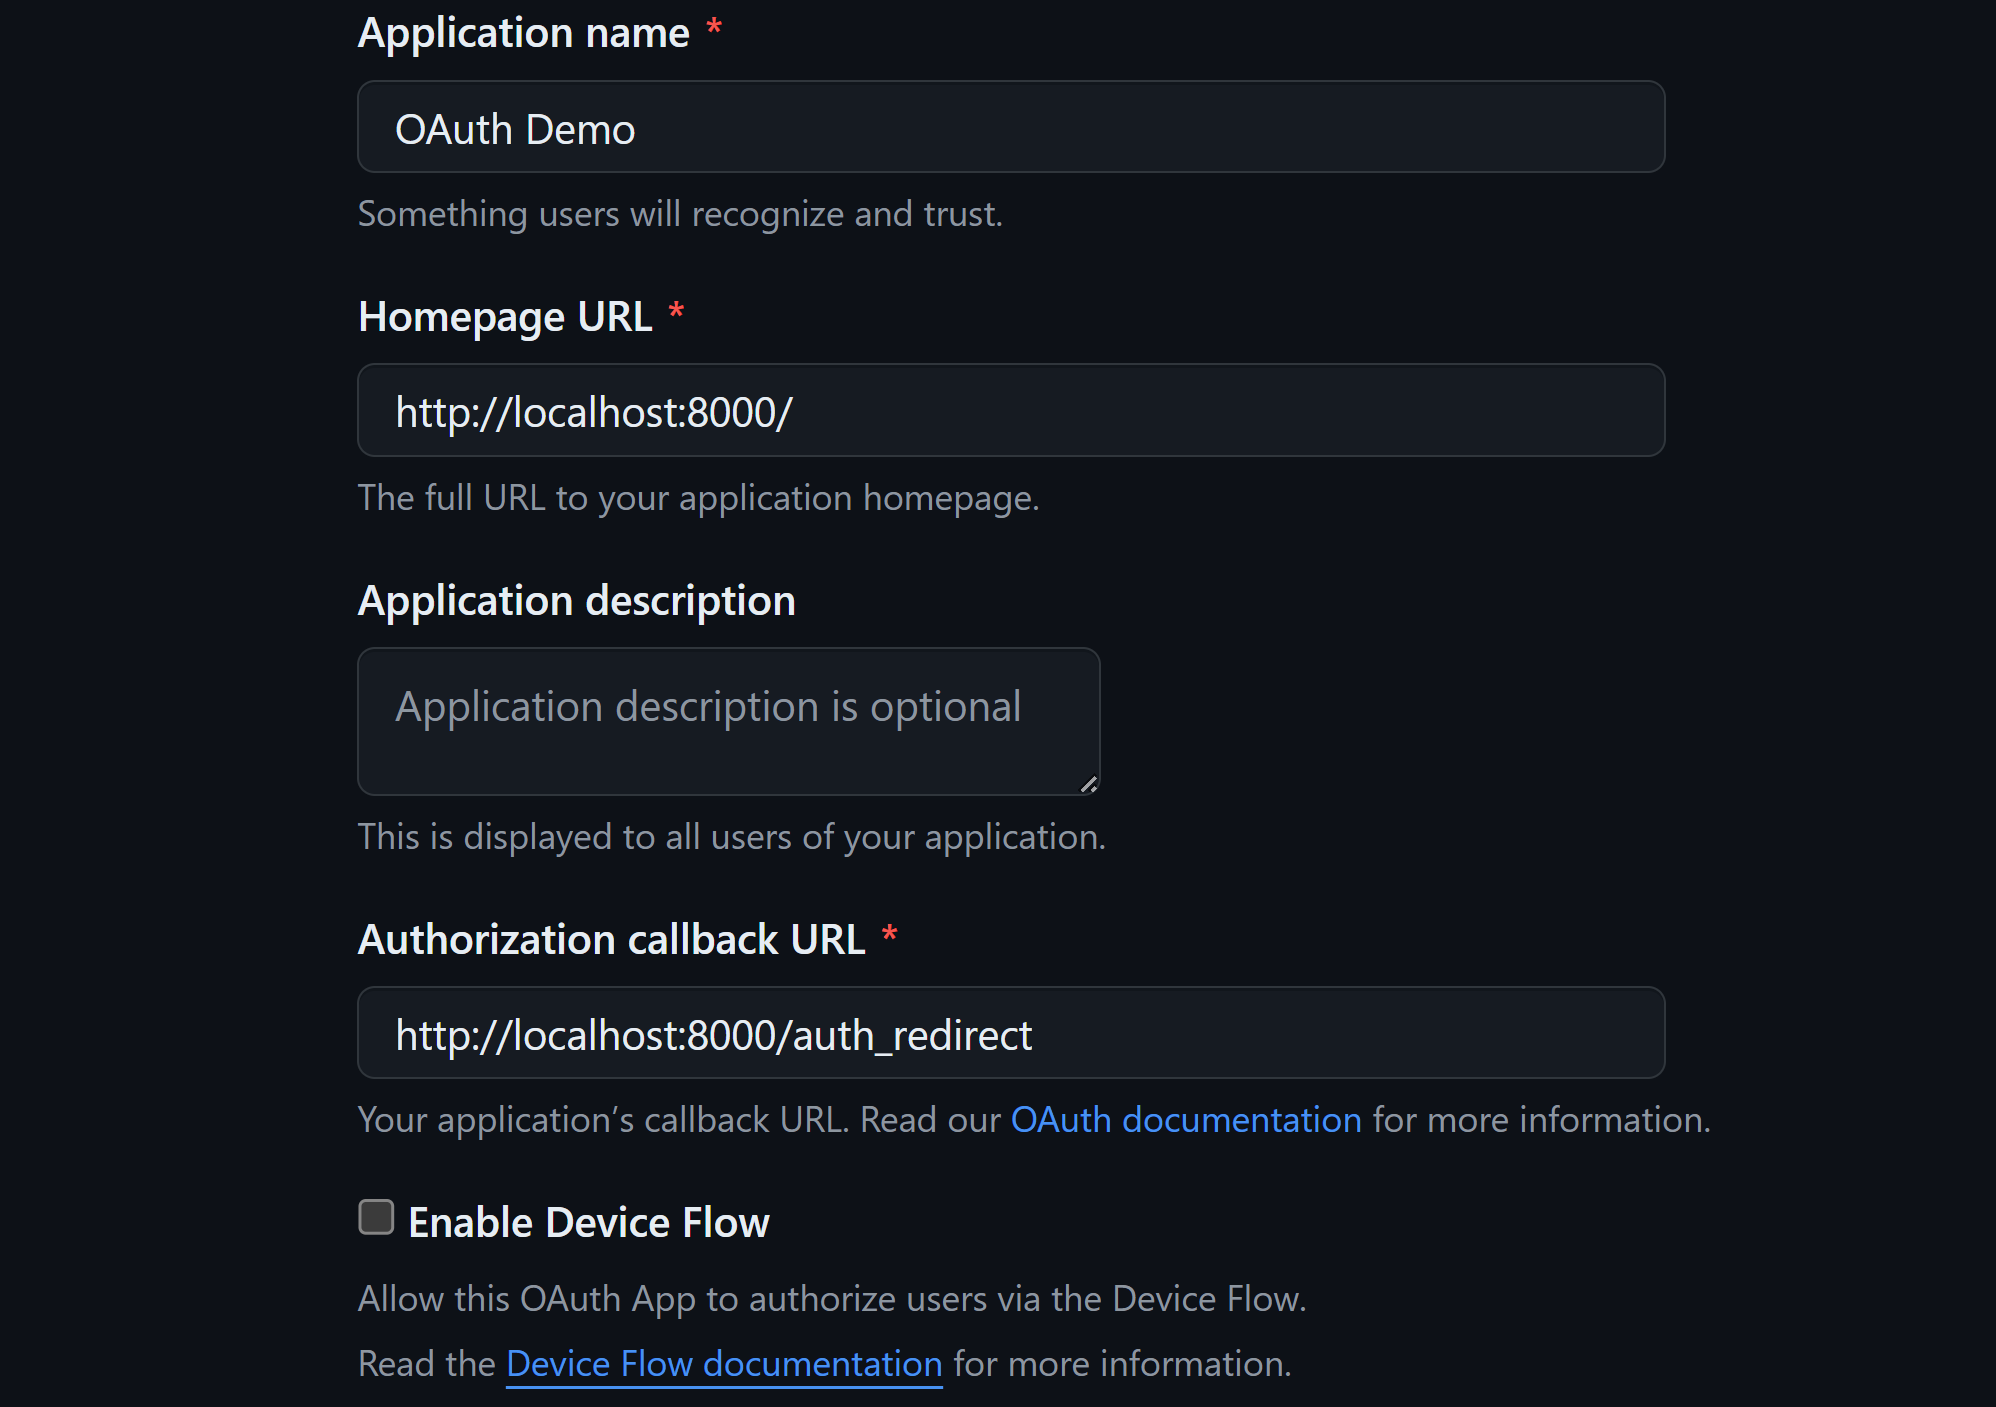

You'll then see a screen where you can view the client ID and generate a client secret. Copy these values and store them in a safe place. 

These values are used to create a `GitHubAppClient` object in FastHTML. This object is responsible for handling the OAuth flow. Here's how you'd set this up:
    
```python
client = GitHubAppClient(
    client_id="your_client_id",
    client_secret="your_client_secret",
    redirect_uri="http://localhost:8000/auth_redirect",
)
```

(It is recommended to store the client ID and secret in environment variables, rather than hardcoding them in your code.)

To start the OAuth flow, you need to redirect the user to the provider's authorization URL. This URL is obtained by calling `client.login_link()`. 

Once you send a user to that link, they'll be asked to grant your app permission to access their GitHub account. If they agree, GitHub will redirect them back to your site with a code that you can use to get an access token. To receive this code, you need to set up a route in FastHTML that listens for requests to your redirect uri (`/auth_redirect` in this case). For example:

```python
@app.get('/auth_redirect')
def auth_redirect(code:str):
    return P(f"code: {code}")
```

This code is temporary, and is used to send a request to the provider from the server (up until now only the client has communicated with the provider). You can think of the exchange so far as:

- Client to us: "I want to log in"
- Us to client: "Here's a link to log in"
- Client to provider: "I want to log in via this link"
- Provider to client: "OK, redirecting you to this URL (with a code)"
- Client to us: /auth_redirect?code=... ("Here's the code you need to get the token")

Next we need:

- Us to provider: "A user I told to log in just gave me this code, can I have a token please?"
- Provider to us: "Here's the token"
- Us to provider: "Can I have the user's details please? Here's the token"
- Provider to us: "Here's the user's details"

To go from code to user details, you can use `info = client.retr_info(code)`. Or, if all you need is a unique identifier for the user, you can just use `retr_id` instead:

```python
@app.get('/auth_redirect')
def auth_redirect(code:str):
    user_id = client.retr_id(code)
    return P(f"User id: {user_id}")
```

There's not much use in just printing the user info - going forward we want to be able to persistently keep track of who this user is. One conveneint way to do this is to store the user ID in the `session` object. Since this is cryptographically signed, it's safe to store sensitive information here - the user can't read it, but we can fetch it back out for any future requests they make. On the server side, you could also store this information in a database if you need to keep track of user info. 


Here's a minimal app that puts all these pieces together:

```python
from fasthtml.common import *
from fasthtml.oauth import GitHubAppClient


# # Set up a database
db = database('data/user_counts.db')
user_counts = db.t.user_counts
if user_counts not in db.t:
    user_counts.create(dict(name=str, count=int), pk='name')
Count = user_counts.dataclass()

# Auth client setup for GitHub
client = GitHubAppClient(os.getenv("AUTH_CLIENT_ID"), 
                         os.getenv("AUTH_CLIENT_SECRET"),
                         redirect_uri="http://localhost:8000/auth_redirect")
login_link = client.login_link()

def before(req, session):
    auth = req.scope['auth'] = session.get('user_id', None)
    if not auth: return RedirectResponse('/login', status_code=303)
    user_counts.xtra(name=auth)
bware = Beforeware(before, skip=['/login', '/auth_redirect'])

app = FastHTML(before=bware)

@app.get('/')
def home(auth):
    return Div(
        P("Count demo"),
        P(f"Count: ", Span(user_counts[auth].count, id='count')),
        Button('Increment', hx_get='/increment', hx_target='#count'),
        P(A('Logout', href='/logout'))  # Link to log out,
    )

@app.get('/increment')
def increment(auth):
    c = user_counts[auth]
    c.count += 1
    return user_counts.upsert(c).count

@app.get('/login')
def login(): return P(A('Login with GitHub', href=client.login_link()))

@app.get('/logout')
def logout(session):
    session.pop('user_id', None)
    return RedirectResponse('/login', status_code=303)

@app.get('/auth_redirect')
def auth_redirect(code:str, session):
    if not code: return "No code provided!"
    user_id = client.retr_id(code)
    session['user_id'] = user_id
    if user_id not in user_counts:
        user_counts.insert(name=user_id, count=0)
    return RedirectResponse('/', status_code=303)

serve(port=8000)
```

Some things to note:

- The `before` function is used to check if the user is authenticated. If not, they are redirected to the login page.
- To log the user out, we remove the user ID from the session.
- Calling `counts.xtra(name=auth)` ensures that only the row corresponding to the current user is accessible when responding to a request. This is often nicer than trying to remember to filter the data in every route, and lowers the risk of accidentally leaking data.
- In the `auth_redirect` route, we store the user ID in the session and create a new row in the `user_counts` table if it doesn't already exist. 


You can find more heavily-commented version of this code in the [oauth directory in fasthtml-example](https://github.com/AnswerDotAI/fasthtml-example/tree/main/oauth_example), along with an even more minimal example. More examples may be added in the future.

### Revoking Tokens (Google)

When the user in the example above logs out, we remove their user ID from the session. However, the user is still logged in to GitHub. If they click 'Login with GitHub' again, they'll be redirected back to our site without having to log in again. This is because GitHub remembers that they've already granted our app permission to access their account. Most of the time this is convenient, but for testing or security purposes you may want a way to revoke this permission.

As a user, you can usually revoke access to an app from the provider's website (for example, [https://github.com/settings/applications](https://github.com/settings/applications)). But as a developer, you can also revoke access programmatically - at least with some providers. This requires keeping track of the access token (stored in client.token["access_token"] after you call `retr_info`), and sending a request to the provider's revoke URL:

```python
authoization_revoke_url = "https://accounts.google.com/o/oauth2/revoke"
def revoke_token(token):
    response = requests.post(authoization_revoke_url, params={"token": token})
    return response.status_code == 200 # True if successful
```

Not all proivders support token revocation, and it is not built into FastHTML clients at the moment. 

### Using State (Hugging Face)

Imagine a user (not logged in) comes to your AI image editing site, starts testing things out, and then realizes they need to sign in before they can click "Run (Pro)" on the edit they're working on. They click "Sign in with Hugging Face", log in, and are redirected back to your site. But now they've lost their in-progress edit and are left just looking at the homepage! This is an example of a case where you might want to keep track of some additional state. Another strong use case for being able to pass some uniqie state through the OAuth flow is to prevent something called a [CSRF attack](https://en.wikipedia.org/wiki/Cross-site_request_forgery). To add a state string to the OAuth flow, you can use `client.login_link_with_state(state)` instead of `client.login_link()`, like so:

```python
# in login page:
link = A('Login with GitHub', href=client.login_link_with_state(state='current_prompt: add a unicorn'))

# in auth_redirect:
@app.get('/auth_redirect')
def auth_redirect(code:str, session, state:str=None):
    print(f"state: {state}") # Use as needed
    ...
```

The state string is passed through the OAuth flow and back to your site.

### A Work in Progress

This page (and OAuth support in FastHTML) is a work in progress. Questions, PRs, and feedback are welcome!